In [1]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import signal

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


##### Using https://www.youtube.com/watch?v=5VyLAH8BhF8 as reference, an attempt at estimating optical flow using the Lucas-Kanade method. Both using overdetermined system directly and also by minimizing least squares.

In [2]:
# read original peds1 images
img1 = mpimg.imread("/Users/tnybny/Documents/Anomaly detection in video/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test001/001.tif",
                   format = 'tif')
img2 = mpimg.imread("/Users/tnybny/Documents/Anomaly detection in video/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test001/002.tif",
                   format = 'tif')

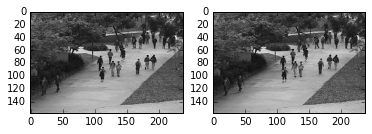

In [3]:
# view original images
plt.subplot(1, 2, 1)
plt.imshow(img1, cmap = 'gray')
plt.subplot(1, 2, 2)
plt.imshow(img2, cmap = 'gray')

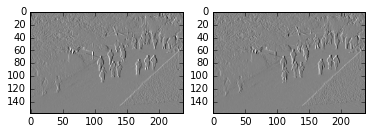

In [4]:
# calculate gradients along x direction
filter_x = np.transpose(np.array([[-1., -1.], [1., 1.]]))
f_x1 = signal.convolve2d(img1, filter_x, mode = 'same')
f_x2 = signal.convolve2d(img2, filter_x, mode = 'same')
plt.subplot(1, 2, 1)
plt.imshow(f_x1, cmap = 'gray')
plt.subplot(1, 2, 2)
plt.imshow(f_x2, cmap = 'gray')

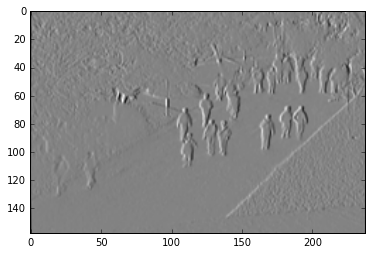

In [5]:
f_x = f_x1 + f_x2
plt.imshow(f_x, cmap = 'gray')

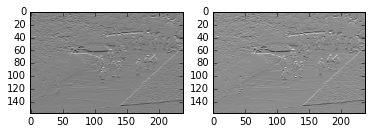

In [6]:
# calculate gradients along y direction
filter_y = np.array([[-1., -1.], [1., 1.]])
f_y1 = signal.convolve2d(img1, filter_y, mode = 'same')
f_y2 = signal.convolve2d(img2, filter_y, mode = 'same')
plt.subplot(1, 2, 1)
plt.imshow(f_y1, cmap = 'gray')
plt.subplot(1, 2, 2)
plt.imshow(f_y2, cmap = 'gray')

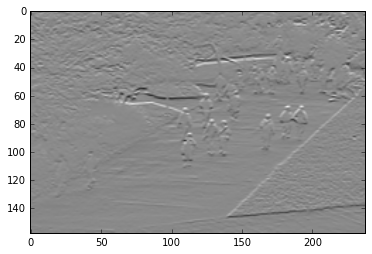

In [7]:
f_y = f_y1 + f_y2
plt.imshow(f_y, cmap = 'gray')

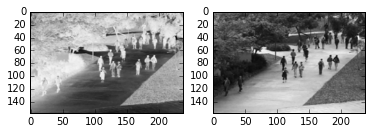

In [8]:
# calculate gradient along t direction
filter_t1 = np.array([[-1., -1.], [-1., -1.]])
f_t1 = signal.convolve2d(img1, filter_t1, mode = 'same')
filter_t2 = np.array([[1., 1.], [1., 1.]])
f_t2 = signal.convolve2d(img2, filter_t2, mode = 'same')
plt.subplot(1, 2, 1)
plt.imshow(f_t1, cmap = 'gray')
plt.subplot(1, 2, 2)
plt.imshow(f_t2, cmap = 'gray')

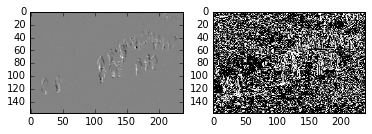

In [9]:
f_t = f_t1 + f_t2
f_ts = np.subtract(img2, img1)
# taking average over 4 pixels with the for each pixel isn't the same as img2 - img1 
plt.subplot(1, 2, 1)
plt.imshow(f_t, cmap = 'gray')
plt.subplot(1, 2, 2)
plt.imshow(f_ts, cmap = 'gray')

In [10]:
filter_lap = np.array([[0, -1./4, 0], [-1./4, 1., -1./4], [0, -1./4, 0]])
u = np.zeros(img1.shape)
v = np.zeros(img1.shape)

In [11]:
# solve overdetermined system by assuming that optical flow is constant in a 3 by 3 window centered on each pixel
for i in xrange(1, u.shape[0]):
    for j in xrange(1, u.shape[1]):
        f_x9 = f_x[i - 1:i + 2, j - 1:j + 2].flatten()
        f_y9 = f_y[i - 1:i + 2, j - 1:j + 2].flatten()
        ft = f_t[i - 1:i + 2, j - 1:j + 2].flatten()
        A = np.vstack((f_x9, f_y9)).T
        res = np.matmul(np.matmul(np.linalg.pinv(np.matmul(A.T, A)), A.T), ft)
        u[i, j] = res[0]
        v[i, j] = res[1]
        

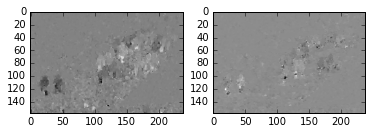

In [12]:
plt.subplot(1, 2, 1)
plt.imshow(u, cmap = 'gray')
plt.subplot(1, 2, 2)
plt.imshow(v, cmap = 'gray')

In [13]:
n, m = u.shape
u_deci = u[np.ix_(range(0, n, 5), range(0, m, 5))]
v_deci = v[np.ix_(range(0, n, 5), range(0, m, 5))]
[X,Y] = np.meshgrid(np.arange(m, dtype = 'float64'), np.arange(n, dtype = 'float64'))
X_deci = X[np.ix_(range(0, n, 5), range(0, m, 5))]
Y_deci = Y[np.ix_(range(0, n, 5), range(0, m, 5))]

## plt.figure()
plt.imshow(img1, cmap = 'gray')
plt.quiver(X_deci, Y_deci, u_deci, v_deci)
# kind of bad, so noisy

In [15]:
# try least squares fit instead, we expect it is less error, smoother field
for i in xrange(1, u.shape[0]):
    for j in xrange(1, u.shape[1]):
        u_num = - np.sum(np.power(f_y[i - 1:i + 2, j - 1:j + 2], 2)) * \
        np.sum(np.multiply(f_x[i - 1:i + 2, j - 1:j + 2], f_t[i - 1:i + 2, j - 1:j + 2])) + \
        np.sum(np.multiply(f_x[i - 1:i + 2, j - 1:j + 2], f_y[i - 1:i + 2, j - 1:j + 2])) * \
        np.sum(np.multiply(f_y[i - 1:i + 2, j - 1:j + 2], f_t[i - 1:i + 2, j - 1:j + 2]))
        u_denom = np.sum(np.power(f_x[i - 1:i + 2, j - 1:j + 2], 2)) * \
        np.sum(np.power(f_y[i - 1:i + 2, j - 1:j + 2], 2)) - \
        np.power(np.sum(np.multiply(f_x[i - 1:i + 2, j - 1:j + 2], f_y[i - 1:i + 2, j - 1:j + 2])), 2)
        
        v_num = np.sum(np.multiply(f_x[i - 1:i + 2, j - 1:j + 2], f_t[i - 1:i + 2, j - 1:j + 2])) * \
        np.sum(np.multiply(f_x[i - 1:i + 2, j - 1:j + 2], f_y[i - 1:i + 2, j - 1:j + 2])) - \
        np.sum(np.power(f_x[i - 1:i + 2, j - 1:j + 2], 2)) * \
        np.sum(np.multiply(f_y[i - 1:i + 2, j - 1:j + 2], f_t[i - 1:i + 2, j - 1:j + 2]))
        v_denom = np.sum(np.power(f_x[i - 1:i + 2, j - 1:j + 2], 2)) * \
        np.sum(np.power(f_y[i - 1:i + 2, j - 1:j + 2], 2)) - \
        np.power(np.sum(np.multiply(f_x[i - 1:i + 2, j - 1:j + 2], f_y[i - 1:i + 2, j - 1:j + 2])), 2)
        
        u[i, j] = u_num / u_denom
        v[i, j] = v_num / v_denom

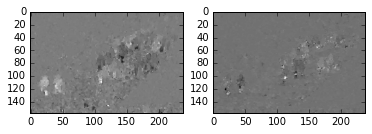

In [16]:
plt.subplot(1, 2, 1)
plt.imshow(u, cmap = 'gray')
plt.subplot(1, 2, 2)
plt.imshow(v, cmap = 'gray')

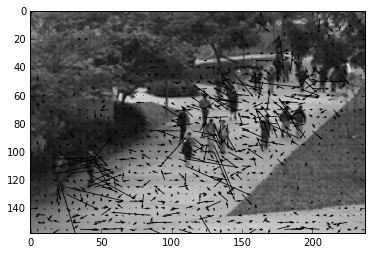

In [17]:
u_deci = u[np.ix_(range(0, n, 5), range(0, m, 5))]
v_deci = v[np.ix_(range(0, n, 5), range(0, m, 5))]
plt.figure()
plt.imshow(img1, cmap = 'gray')
plt.quiver(X_deci, Y_deci, u_deci, v_deci)
# Maybe its a little better? Can't really say...
# Looks like there is a lot of confusion when there is a large amount of motion. Need pyramids maybe?